In [1]:
%matplotlib inline
import numpy as np
import ringdown as rd
import arviz as az
from pycbc.types import TimeSeries
import h5py
from scipy.interpolate import interp1d

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# Plot waveform in time domain

In [3]:
fit = rd.Fit(model='mchi_aligned')
fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate2048_pystan.nc')

In [4]:
h = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
lp = fit.result.sample_stats.lp.stack(samples=('chain','draw'))#log posterior
imaxlp = np.argmax(lp.values)
hmax = h.values[0,:,imaxlp]

In [5]:
hpycbc = TimeSeries(hmax,delta_t=1/2048)

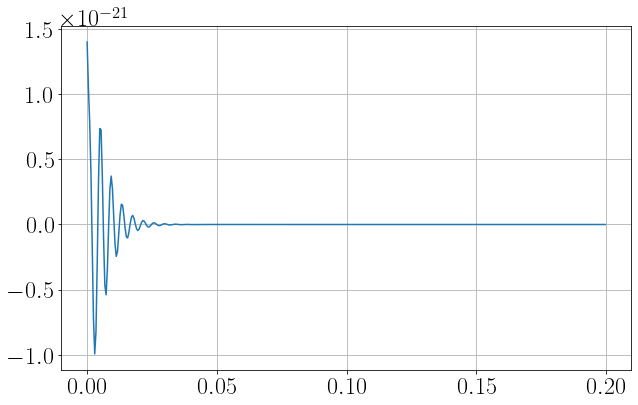

In [6]:
plt.plot(hpycbc.sample_times,hpycbc)

# Plot posterior of A221 for srate = 2048 and 4096

Text(0.5, 0, 'A221')

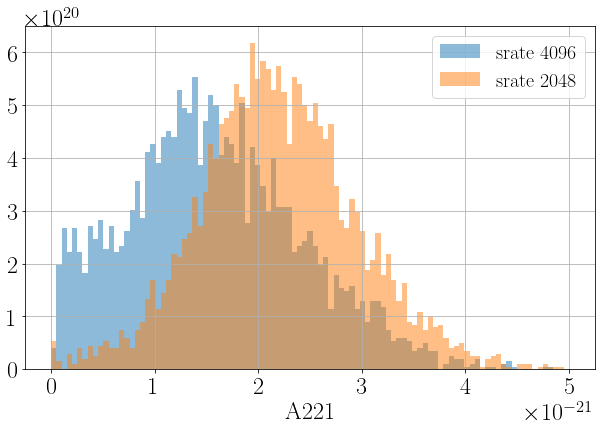

In [7]:
fit4096 = rd.Fit(model='mchi_aligned')
fit2048 = rd.Fit(model='mchi_aligned')

fit4096.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0602_srate4096.nc')
fit2048.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate2048_pystan.nc')

A4096 = fit4096.result.posterior.A.stack(samples=('chain','draw'))
A2048 = fit2048.result.posterior.A.stack(samples=('chain','draw'))

bins = np.linspace(0,5e-21,100)
plt.hist(A4096[1].values,alpha=0.5,bins=bins,density=True,label='srate 4096')
plt.hist(A2048[1].values,alpha=0.5,bins=bins,density=True,label='srate 2048')
plt.legend()
plt.xlabel('A221')
#plt.savefig('/work/yifan.wang/WWW/GWevents/figure/A221pos.png',bbox_inches='tight')

In [8]:
p = A4096[1].values
np.median(p)/np.std(p)

1.8051892520833734

In [9]:
mf = fit4096.result.posterior.M.stack(samples=('chain','draw'))
af = fit4096.result.posterior.chi.stack(samles=('chain','draw'))
mfmax = mf.values[imaxlp]
afmax = af.values[imaxlp]
mfmax,afmax

(82.04584602455077, 0.8811227488608455)

In [10]:
print('For srate 4096 Hz, mode 220 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 0, l=2, m=2))

For srate 4096 Hz, mode 220 f and tau are:  (256.4451741637538, 0.005968168269336123)


In [11]:
print('For srate 4096 Hz, mode 221 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 1, l=2, m=2))

For srate 4096 Hz, mode 221 f and tau are:  (254.5565810641483, 0.0019818180384027387)


In [12]:
mf = fit2048.result.posterior.M.stack(samples=('chain','draw'))
af = fit2048.result.posterior.chi.stack(samles=('chain','draw'))
mfmax = mf.values[imaxlp]
afmax = af.values[imaxlp]
mfmax,afmax

(76.44821752123468, 0.7821620400355006)

In [13]:
print('For srate 2048 Hz, mode 220 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 0, l=2, m=2))

For srate 2048 Hz, mode 220 f and tau are:  (242.996818266059, 0.004902710793961671)


In [14]:
print('For srate 2048 Hz, mode 221 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 1, l=2, m=2))

For srate 2048 Hz, mode 221 f and tau are:  (239.30070353386856, 0.0016246334842544377)


# Plot the $2\times |h(f)| \times \sqrt{f}$

In [15]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain
    
def plot_snr_eachbin(path='/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0602_srate4096.nc',
               srate=4096):
    '''
    Plot a figure, return fit (a ringdown class)
    '''
    fit = rd.Fit(model='mchi_aligned')
    fit.result = az.from_netcdf(path)
    
    #Read in strain data
    ifos = ['H1', 'L1']
    input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
    raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}
    for s in raw_strain.values():
        fit.add_data(s)
    T = 0.2
    fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
    # condition data
    fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
    fit.compute_acfs()
    
    #read in maxL waveform template
    hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
    lp = fit.result.sample_stats.lp.stack(samples=('chain','draw'))
    imaxlp = np.argmax(lp.values)
    for ifo in ['H1','L1']:
        if ifo == 'H1':
            hsmax = hs.values[0,:,imaxlp]
            psd = fit.data['H1'].get_psd()
        elif ifo == 'L1':
            hxmas = hs.values[1,:,imaxlp]
            psd = fit.data['L1'].get_psd()
        #save the waveform into a PyCBC TimeSeries type
        h = TimeSeries(hsmax,delta_t=1/srate)
        hfreq = h.to_frequencyseries()
        #plot figures for H1 and L1 separately
        plt.figure()
        
        #psdinterp = interp1d(psd.index.values,psd.values)
        f = hfreq.sample_frequencies
        #df = f[1]-f[0]
        snr_integrand = 2 * abs(hfreq.data) * f**0.5
        plt.plot(f,snr_integrand,label=str(ifo)+' $2|h(f)|\sqrt{f}$ (maxL waveform)')
        plt.plot(psd.index.values[1:],np.sqrt(psd.values[1:]),label=str(ifo)+' ASD')
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        #optimal_snr = np.sqrt(2*np.sum(snr_integrand))
        plt.title('sample rate '+str(srate)+' '+str(ifo))
        plt.savefig(str(ifo)+'_srate'+str(srate)+'.png',bbox_inches='tight')
        
        #save txt
        np.savetxt(str(ifo)+'_'+'srate'+str(srate)+'_whitenh.txt',np.transpose([f,snr_integrand]))
        np.savetxt(str(ifo)+'_'+'srate'+str(srate)+'_asd.txt',np.transpose([psd.index.values,np.sqrt(psd.values)]))
    return fit

# ASD plot

In [16]:
h1_8192_asd = np.loadtxt('./H1_srate8192_asd.txt')

In [17]:
ligoasd = np.loadtxt('/work/yifan.wang/GWOSC-data/gwtc_1/GW150914-asd/H1-GDS-CALIB_STRAIN.txt')

In [18]:
h_raw_strain = read_strain('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/H-H1_GWOSC_16KHZ_R1-1126257415-4096.hdf5', 'H1')

In [19]:
h_raw_psd = h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp))

In [20]:
h_raw_psd

0.0       3.872659e-41
1.0       1.907259e-41
2.0       3.248109e-42
3.0       2.328614e-41
4.0       2.612500e-40
              ...     
8188.0    1.854064e-52
8189.0    7.554492e-53
8190.0    1.876581e-53
8191.0    4.006861e-54
8192.0    3.018476e-55
Length: 8193, dtype: float64

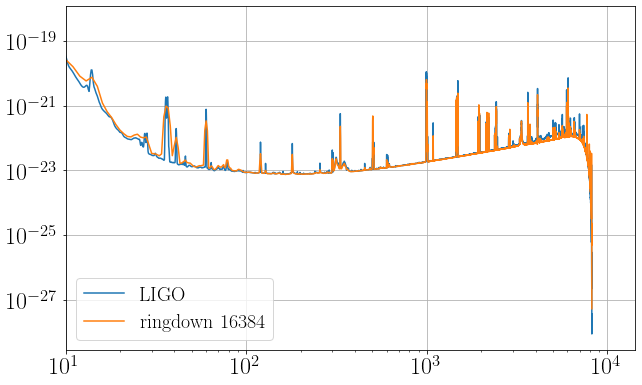

In [21]:
#plt.loglog(h1_8192_asd[:,0],h1_8192_asd[:,1],label='Max Isi estimated')
plt.loglog(ligoasd[:,0],ligoasd[:,1],label='LIGO')
plt.loglog(h_raw_psd.index,np.sqrt(h_raw_psd.values),label='ringdown 16384')
plt.xlim(10,)
plt.legend()

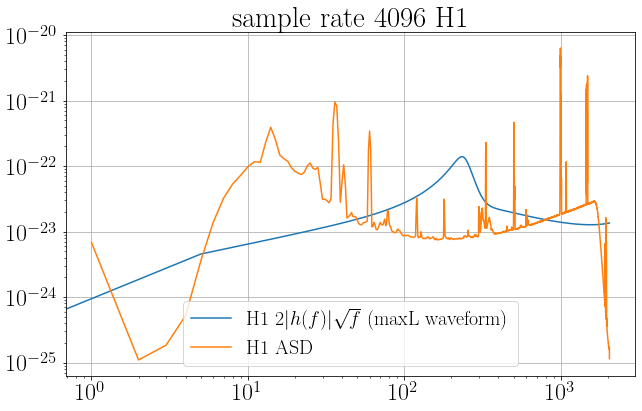

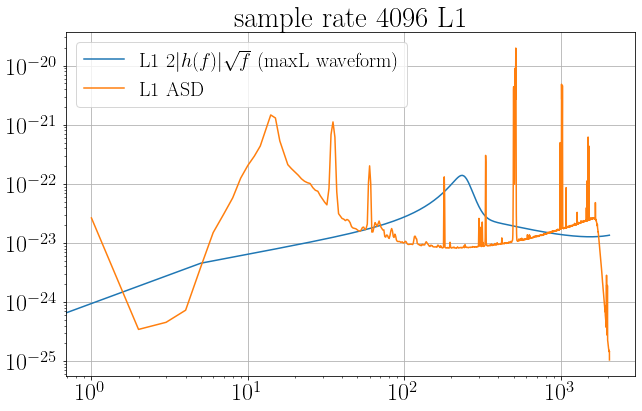

In [22]:
fit4 = plot_snr_eachbin(path='/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0602_srate4096.nc',
               srate=4096)

In [23]:
h_raw_strain.fsamp

16384.0

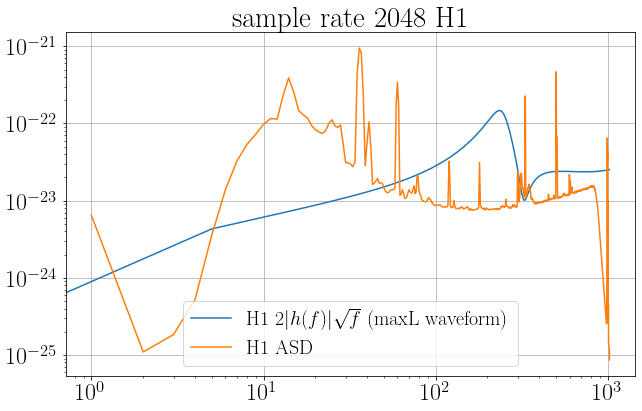

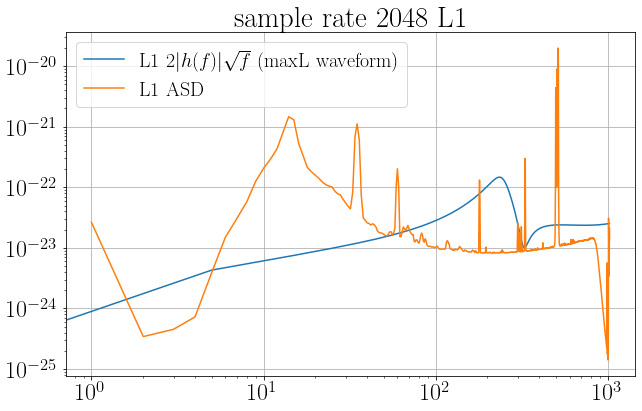

In [24]:
plot_snr_eachbin('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate2048_pystan.nc',2048)

# 8192 Hz result

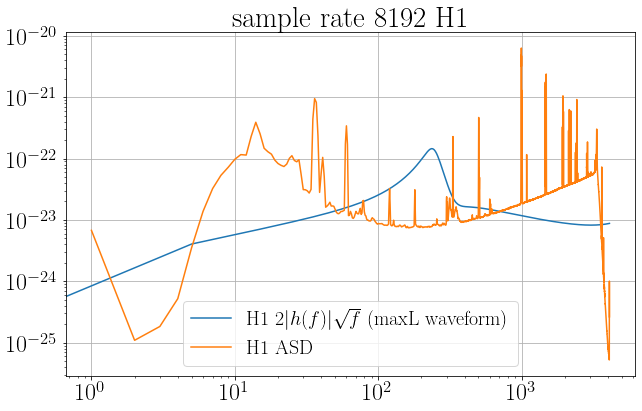

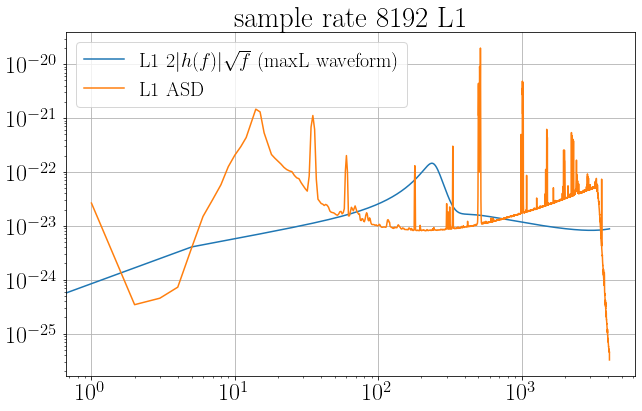

In [25]:
plot_snr_eachbin(path='/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate8192_pystan.nc',
               srate=8192)

In [26]:
h1_4096_asd = np.loadtxt('./H1_srate4096_asd.txt')
h1_4096_wh = np.loadtxt('./H1_srate4096_whitenh.txt')
h1_2048_asd = np.loadtxt('./H1_srate2048_asd.txt')
h1_2048_wh = np.loadtxt('./H1_srate2048_whitenh.txt')
h1_8192_asd = np.loadtxt('./H1_srate8192_asd.txt')
h1_8192_wh = np.loadtxt('./H1_srate8192_whitenh.txt')

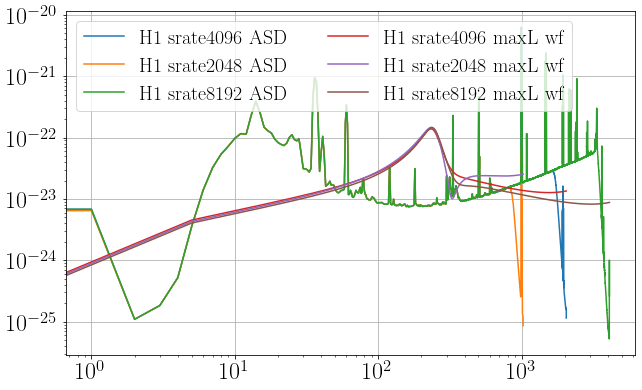

In [27]:
plt.plot(h1_4096_asd[:,0],h1_4096_asd[:,1],label='H1 srate4096 ASD')
plt.plot(h1_2048_asd[:,0],h1_2048_asd[:,1],label='H1 srate2048 ASD')
plt.plot(h1_8192_asd[:,0],h1_8192_asd[:,1],label='H1 srate8192 ASD')
plt.plot(h1_4096_wh[:,0],h1_4096_wh[:,1],label='H1 srate4096 maxL wf')
plt.plot(h1_2048_wh[:,0],h1_2048_wh[:,1],label='H1 srate2048 maxL wf')
plt.plot(h1_8192_wh[:,0],h1_8192_wh[:,1],label='H1 srate8192 maxL wf')
plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=2)
plt.savefig('H1_compared2048_4096.png',bbox_inches='tight')

# PyCBC waveform generator

In [107]:
from pycbc.inference.models.gaussian_noise import create_waveform_generator
from pycbc.inference import io,models

In [108]:
# load the posterior file
fp = io.loadfile('/work/yifan.wang/more_ringdown/runs/pycbc/srate4096-low20-high1024/result.hdf', 'r')
# get the config, the data, and PSDs from the file
# the config file:
cp = fp.read_config_file()
# the data
data = fp.read_data()
# the psds
psds = fp.read_psds()
model = models.read_from_config(cp, data=data, psds=psds)

In [109]:
# let's get the maximum likelihood point
samples = fp.read_samples(list(fp['samples'].keys()))
maxlidx = samples['loglikelihood'].argmax()
maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}

In [110]:
# get the loglikelihood of these points
model.update(**maxlparams)
model.loglikelihood

-324786.2978462413

In [111]:
static_p = model.static_params
static_p['apprxoimant'] = 'FdQNMfromFinalMassSpin'

In [112]:
waveform_generator = create_waveform_generator(
            model.variable_params, model.data,
            waveform_transforms=model.waveform_transforms,
            recalibration=model.recalibration,
            gates=model.gates, **static_p)

In [113]:
model.current_params

{'final_mass': 75.20520112467264,
 'final_spin': 0.764878620668266,
 'amp220': 6.347412800746856e-21,
 'phi220': 3.9695482243866906,
 'absamp221': 1.040213802677726e-20,
 'phi221': 0.5462890275236133,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265,
 't_gate_start': 1126259460.4083147,
 't_gate_end': 1126259462.4083147,
 'tc': 1126259462.4073148,
 'amp221': 1.6387996737116755}

In [114]:
wf = waveform_generator.generate(**model.current_params)

In [116]:
model220par = model.current_params.copy()
model220par['amp221']=0
model220par['absamp221']=0

model221par = model.current_params.copy()
model221par['amp220'] = model.current_params['amp220']*1e-5
model221par['amp221'] = model.current_params['amp221']*1e5

In [117]:
model.current_params['amp220']

6.347412800746856e-21

In [118]:
model.current_params['amp221']

1.6387996737116755

In [119]:
model220par

{'final_mass': 75.20520112467264,
 'final_spin': 0.764878620668266,
 'amp220': 6.347412800746856e-21,
 'phi220': 3.9695482243866906,
 'absamp221': 0,
 'phi221': 0.5462890275236133,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265,
 't_gate_start': 1126259460.4083147,
 't_gate_end': 1126259462.4083147,
 'tc': 1126259462.4073148,
 'amp221': 0}

In [120]:
model221par

{'final_mass': 75.20520112467264,
 'final_spin': 0.764878620668266,
 'amp220': 6.347412800746857e-26,
 'phi220': 3.9695482243866906,
 'absamp221': 1.040213802677726e-20,
 'phi221': 0.5462890275236133,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265,
 't_gate_start': 1126259460.4083147,
 't_gate_end': 1126259462.4083147,
 'tc': 1126259462.4073148,
 'amp221': 163879.96737116756}

In [121]:
wf220 = waveform_generator.generate(**model220par)
wf221 = waveform_generator.generate(**model221par)

In [122]:
wf220['H1'].data

array([-4.61428260e-25+0.00000000e+00j,  4.55195796e-25-7.55856105e-26j,
       -4.36666725e-25+1.49129620e-25j, ...,
       -1.18093442e-25+3.93608395e-25j,  5.15594162e-26-4.07695153e-25j,
        1.63867802e-26+4.10615650e-25j])

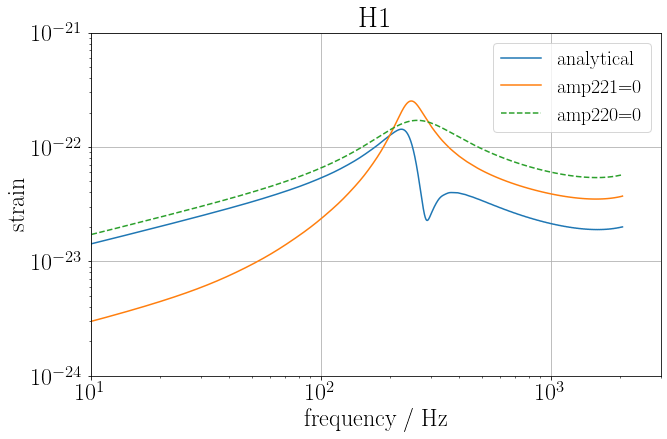

In [124]:
ifo = 'H1'
f = wf[ifo].sample_frequencies
f220 = wf220[ifo].sample_frequencies
f221 = wf221[ifo].sample_frequencies
plt.figure()
plt.loglog(f,2*abs(wf[ifo])*np.sqrt(f),label='analytical')
plt.loglog(f220,2*abs(wf220[ifo])*np.sqrt(f220),label='amp221=0')
plt.loglog(f221,2*abs(wf221[ifo])*np.sqrt(f221),ls='--',label='amp220=0')
plt.xlim(10,3000)
plt.ylim(1e-24,1e-21)
plt.title(str(ifo))
plt.xlabel('frequency / Hz')
plt.ylabel('strain')
plt.legend()